# What is the problem and my approach? 

This exercise is an example of "one-class classification(OCC)" problem in machine learning. One-class classifiers are trained using samples of just the class of interest. In other words, these kind of classifiers are able to decide whether a new observation belongs to the same distribution as existing observations (it is an inlier), or should be considered as different (it is an outlier). 

The OCC problem is often solved by estimating the target density. Based on my research, SVM-based algorithms can solve perfectly such a problem. Particularly, One Class Support Vector Machines (OCSVM), that requires only positive samples as a training set, was successful to generate good results in different studies. 

However, due to the lack of negative training samples, OCSVM normally suffers from an over-fitting problem. So, considering the best value for arameters is a challange.

This excesize is a high dimentional problem. Therefore, I used the Radial Basis Function (RBF) kernel for OCSVM to facilitate dealing with the high-dimension features. Two parameters needed to be determined during the training: the RBF kernel width represented by gamma and the rejection fraction, nu. 


In summary, I made the model in three different approaches:
1. making model without doing any feature engineering -  accuracy: 0.91, AUC = 0.96
2. making model using feature reduction - accuracy: 0.85 ,  AUC = 0.67
3. making model using feature selection - accuracy: 0.93 , AUC = 0.98
   
As can be seen the feature selection is very important for this model. So, it seems that using more proficient method for feature selection such as clustering-based feature selection can improve the accuracy.

# Looking at the quality of data

It might be helpful to see what percentage of the values in our dataset were missing. Both datasets, trainingData and testingData, have 10% missing values. That seems like a lot. 
We need a prepeocessing step to resolve such issues. The description of each colum is required to investigate carefully the consistency of values. I do not have access to the description, so I assumed they are consistent in terms of range and type.   

In [1]:
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import warnings; warnings.simplefilter('ignore')


train_data = pd.read_csv("D:/Hassan/Data/trainingData.csv", header=None, skiprows=1)
#train_data.sample(10)

label = pd.to_numeric(train_data.loc[:,243])
train_data_without_label = train_data.drop([243], axis=1)

total_value = np.product(train_data_without_label.shape)
missing_values_count = train_data_without_label.isnull().sum()
total_missing = missing_values_count.sum()
percentage = (total_missing / total_value)*100
print('missing data percentage in training data:', percentage)


missing data percentage in training data: 9.872185398717932


In [3]:
# reading test data and looking at the percentage of missing value

test_data = pd.read_csv("D:/Hassan/Data/testingData.csv", header=None, skiprows=1)

total_value = np.product(test_data.shape)
missing_values_count = test_data.isnull().sum()
total_missing = missing_values_count.sum()
percentage = (total_missing / total_value)*100
print('missing data percentage in testing data:', percentage)

test_data_label = pd.to_numeric(test_data.loc[:,243])
test_data_without_label = test_data.drop([243], axis=1)


missing data percentage in testing data: 9.816834475803004


# Preprocessing

There are 10% missing values in the both datasets. So, I did following steps to resolve the missing values issue:
1. I dropped all columns with more than 50 percent missing values.
2. I filled the remaining missing values with the value that comes directly before it in the same column. So, the value will be propagated in the case of existing a sequence of NaN value.  


In [4]:
#Step 1: remove all columns with more than 50 percent missing value

columns_with_na_dropped = train_data_without_label.dropna(axis=1, thresh=train_data_without_label.shape[0] /2)
#columns_with_na_dropped.shape

#Step 2: replace all NA's with the value that comes directly before it in the same column
train_data_na_free = columns_with_na_dropped.fillna(method='ffill')

total_value = np.product(train_data_na_free.shape)
missing_values_count = train_data_na_free.isnull().sum()
total_missing = missing_values_count.sum()
percentage = (total_missing / total_value)*100
print("Percentage of missing value for traingData: %f \n" % percentage)

#---------------------------------------------
# The same procedure for Test Data

test_columns_with_na_dropped = test_data_without_label.dropna(axis=1, thresh=test_data_without_label.shape[0] /2)

# replace all NA's with the value that comes directly before it in the same column
test_data_na_free = test_columns_with_na_dropped.fillna(method='ffill')

total_value = np.product(test_data_na_free.shape)
missing_values_count = test_data_na_free.isnull().sum()
total_missing = missing_values_count.sum()
percentage = (total_missing / total_value)*100
print("Percentage of missing value for testingData: %f \n" % percentage)

print ('training data shape:',train_data_na_free.shape)
print ('testing data shape:',test_data_na_free.shape)



Percentage of missing value for traingData: 0.000000 

Percentage of missing value for testingData: 0.000000 

training data shape: (2833, 220)
testing data shape: (959, 220)


# Split the training data 

I split the trainingData set into two parts so that I assigned 90% for training and 10% for testing. Later, I will use the testing portion for the validation of the classifier. 

In [5]:
from sklearn.model_selection import train_test_split

real_test = test_data_na_free
X = train_data_na_free
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state=0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


X_train shape: (2549, 220)
X_test shape: (284, 220)


#  Standardization & Visualization

I used PCA to project the data set on a 2 dimensional space in order to see the distribution of data. PCA is effected by scale so I need to scale the features in data before applying PCA. 
Using StandardScaler helps to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) 
which is a requirement for the optimal performance. 


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

x = train_data_na_free.values

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])

label = pd.to_numeric(train_data.loc[:,243]) #243 is index for the label
finalDf = pd.concat([principalDf, label], axis = 1)

#finalDf.head()
#finalDf[243]

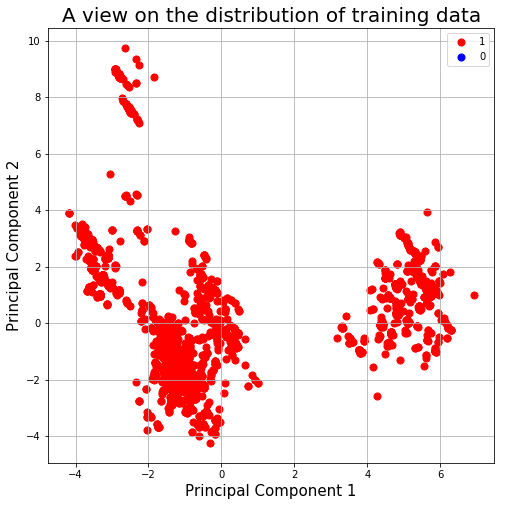

In [7]:
# generate figure for training data
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('A view on the distribution of training data', fontsize = 20)

targets = [1, 0]
colors = ['r', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf[243] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Making the model -  (approach 1)

Since the trainingData set presents the information of the one class (positive class), I made a classifier by using OneClassSVM. The classifier returns +1 or -1 to indicate whether the data is an inlier (in class) or outlier (out of class) respectively. So, I converted -1 to 0 in the prediction values in order to make consistent with provided label.


In [7]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.2)
clf.fit(X_train)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.2, kernel='rbf',
      max_iter=-1, nu=0.01, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

# Validation of the model

Since only one class is presented in y_test, it seems that cross validation cannot show high accuracy for different samples of data. Because cross validation is used to assess the performance of the model on a new data set. Meanwhile, some kinds of scoring have not been defined for oneClassSVM. Basically, oneClassSVM classifier's output for a given instance is a measure of confidence of that instance belonging to the data that was used in training the model.


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics.scorer import SCORERS

#print(sorted(list(SCORERS.keys())))

result = clf.predict(X_test)
targs = y_test

#result contains -1 and 1, so I converted to 0,1
preds = np.ones(shape=(result.shape[0],), dtype=int)
for i in range(result.shape[0]):
    if result[i] == -1: 
        preds[i] = 0        

# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X_test, y_test, cv=5, scoring = 'accuracy'))     

print("accuracy: ", metrics.accuracy_score(targs, preds))  
# print("precision: ", metrics.precision_score(targs, preds))  
# print("recall: ", metrics.recall_score(targs, preds))  
# print("f1: ", metrics.f1_score(targs, preds))  


Cross-validation (accuracy) [0.59649123 0.57894737 0.54385965 0.66666667 0.46428571]
accuracy:  0.8838028169014085


# Tuning the model

Radial Basis Function (RBF) kernel has a a parameter gamma.  Small gamma means a larger similarity radius. The rejection fraction parameter nu controls the upper bound on the fraction of training errors and lower bound of the fraction of support vectors. It can accept values in range (0,1].
I did an exhaustive search over specified parameters values for the classifier. Obviously,assigning the best values to parameters increases the accuracy. However, high accuracy cannot guaranty the good performance for the unseen data. Sometimes, the improvement in model’s accuracy can be due to over-fitting too. As it happens for this case.


In [9]:
from sklearn.model_selection import GridSearchCV

clf = OneClassSVM(kernel="rbf")
grid_values = {'gamma': [0.0001, 0.0045, 0.001, 0.01, 0.2, 1], 'nu':[0.0001, 0.03, 0.01, 0.1]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

Grid best parameter (max. accuracy):  {'nu': 0.01, 'gamma': 0.0001}
Grid best score (accuracy):  0.9858768144370341


# Evaluation of the model

Confusion Matrix-based metrics are powerful methods to measure the performance of the classifier. (As can be seen, TN=253, TP=621, FP=20, FN=65) Here, I used three of them that are usual to provide enough information about the performane of the classifier:

1) Accuracy: is the fraction of samples that were classified correctly [(TP+TN)/total]. I applied the classifier on the testingData in order to see the real accurcy. The accuracy, precision, and recall are relevant to the class of interest so that, it is the class 1 in this case.

In [10]:
from sklearn import metrics  
import matplotlib.pyplot as plt

clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.19)
clf.fit(train_data_na_free)

result = clf.predict(test_data_na_free)

#result contains -1 and 1, so I converted to 0,1
preds = np.ones(shape=(result.shape[0],), dtype=int)
for i in range(result.shape[0]):
    if result[i] == -1: 
        preds[i] = 0

confusion_mat = metrics.confusion_matrix(test_data_label , preds)
print("Confusion matrix: \n", confusion_mat)
print("-----------------------------------------------\n")

print("accuracy: ", metrics.accuracy_score(test_data_label, preds)) 
print("precision: ", metrics.precision_score(test_data_label, preds))  
print("recall: ", metrics.recall_score(test_data_label, preds))  

print("-----------------------------------------------\n")

print(metrics.classification_report(test_data_label, preds, target_names=['class 0', 'class 1']))

y_scores = clf.decision_function(test_data_na_free)
#y_score_list = list(zip(test_data_label[0:20], y_scores[0:20]))
# show the decision_function scores for first 20 instances
#y_score_list


Confusion matrix: 
 [[253  20]
 [ 65 621]]
-----------------------------------------------

accuracy:  0.9113660062565172
precision:  0.968798751950078
recall:  0.9052478134110787
-----------------------------------------------

             precision    recall  f1-score   support

    class 0       0.80      0.93      0.86       273
    class 1       0.97      0.91      0.94       686

avg / total       0.92      0.91      0.91       959



2) Precision-Recall Curve is a usful evaluation method to dtermine the success of the classifier. The x axis shows precision and the y axis shows recall. An ideal classifier would be able to achieve perfect precision of 1.0 and perfect recall of 1.0. So the optimal point would be the upper right corner [1,1]. The average of the precision has been presented by red circle in the following figure.

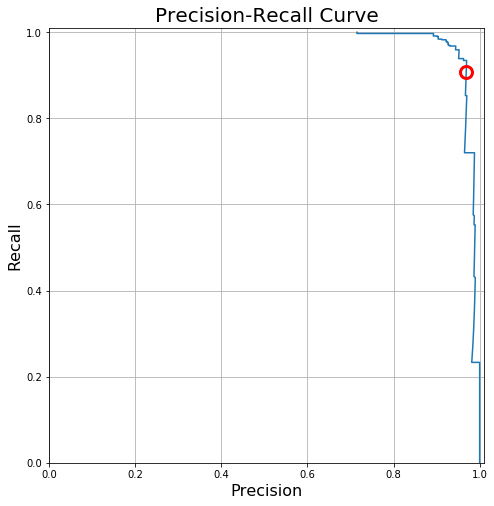

In [11]:
precision, recall, thresholds = metrics.precision_recall_curve(test_data_label, y_scores)

closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize = (8,8))
plt.title('Precision-Recall Curve', fontsize=20)
plt.grid(True)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

3) ROC curve is a visualization method to illustrate the performance of a binary classifier. The ROC curve on the X-axis shows a classifier's False Positive Rate (FPR) so that would go from 0 to 1.0, and on the Y-axis it shows a classifier's True Positive Rate (TPR) so that will also go from 0 to 1.0.  The ideal point in ROC space is one where the classifier achieves a false positive rate of zero, and a true positive rate of one. So, that would be the upper left corner. 
 The Area Under the Curve (AUC) is used to measure the performance. That's the single number that measures the total area underneath the ROC curve as a way to summarize a classifier's performance. So, an AUC of zero represents a very bad classifier, and an AUC of one will represent an optimal classifier. In this case, AUC is 0.96.

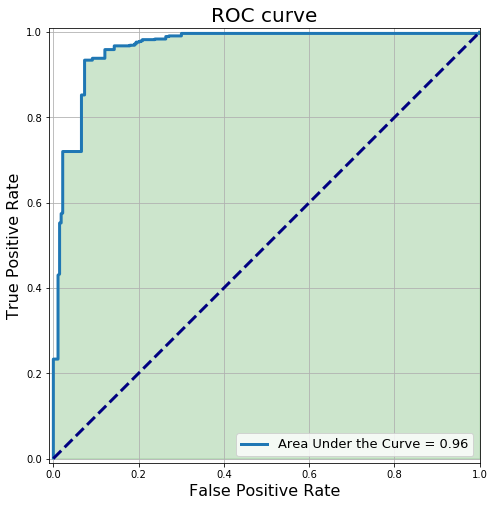

In [12]:
fpr, tpr, _ = metrics.roc_curve(test_data_label, y_scores)
roc_auc_clf = metrics.auc(fpr, tpr)
#print("area under curve (auc): ", metrics.roc_auc_score(test_data_label, preds)) 

plt.figure(figsize = (8,8))
plt.grid(True)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Area Under the Curve = {:0.2f}'.format(roc_auc_clf))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve' , fontsize=20)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='g')
plt.axes().set_aspect('equal')
plt.show()

# Visualize the results

I visualized the predicted class label for test data by classifier in Figure 1. 
Figure 2 shows the true label of the test data.

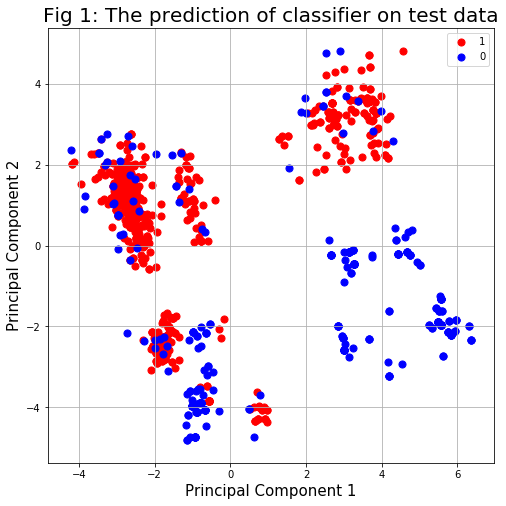

In [13]:
# Apply model on testinData

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

result = clf.predict(test_data_na_free)

#result contains -1 and 1, so I converted to 0,1
preds = np.ones(shape=(result.shape[0],), dtype=int)
for i in range(result.shape[0]):
    if result[i] == -1: 
        preds[i] = 0

x = test_data_na_free.values

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])

result = pd.Series(preds.tolist())  # convert ndarray to series.
finalDf = pd.concat([principalDf, result], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Fig 1: The prediction of classifier on test data', fontsize = 20)

targets = [1, 0]
colors = ['r', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()



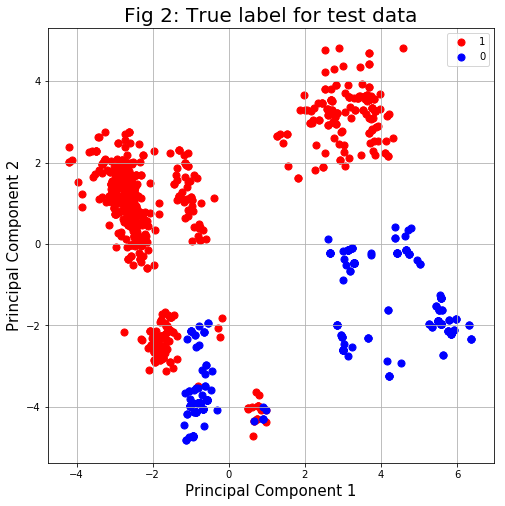

In [14]:
# visualize the test data

x = test_data_na_free.values

# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])

test_data_label = pd.to_numeric(test_data.loc[:,243])
finalDf = pd.concat([principalDf, test_data_label], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Fig 2: True label for test data', fontsize = 20)

targets = [1, 0]
colors = ['r', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf[243] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#  Feature reduction - (approach 2)

I used PCA with 10 components for feature reduction. The values for parameters are the same for the first approach.  
The validation shows high accuracy for the model. However, the accuracy of the model on test data is not better than the first approach. It seems that the model is very prone to overfitting.

In [15]:
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.svm import OneClassSVM


X = train_data_na_free
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state=0)
pca1 = PCA(n_components = 10 )
pca1.fit(X_train)
X_t_train = pca1.transform(X_train)
X_t_test = pca1.transform(X_test)

clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.02)
clf.fit(X_t_train)
#print ('score', clf.score(X_t_test, y_test))


result = clf.predict(X_t_test)
targs = y_test

#result.shape

#result contains -1 and 1, so I converted to 0,1
preds = np.ones(shape=(result.shape[0],), dtype=int)
for i in range(result.shape[0]):
    if result[i] == -1: 
        preds[i] = 0
    
# accuracy is the default scoring metric
#print('Cross-validation (accuracy)', cross_val_score(clf, X_test, y_test, cv=5, scoring = 'accuracy'))        

print("accuracy: ", metrics.accuracy_score(targs, preds))  



accuracy:  0.9788732394366197


In [16]:
# apply model on testing data
pca_test = pca1.transform(test_data_na_free)
#pca_label = pca1.transform(test_data_label)
result = clf.predict(pca_test)

preds = np.ones(shape=(result.shape[0],), dtype=int)
for i in range(result.shape[0]):
    if result[i] == -1: 
        preds[i] = 0

#confusion_mat = confusion_matrix(test_data_label , preds)

print("Accuracy: ", metrics.accuracy_score(test_data_label , preds))
print("------------------------------------------------------\n")

y_scores = clf.decision_function(pca_test)
fpr, tpr, _ = metrics.roc_curve(test_data_label, y_scores)
roc_auc_clf = metrics.auc(fpr, tpr)
print('Area Under the Curve = {:0.2f}'.format(roc_auc_clf))
print("------------------------------------------------------\n")
print(metrics.classification_report(test_data_label, preds, target_names=['class 0', 'class 1']))


Accuracy:  0.8498435870698644
------------------------------------------------------

Area Under the Curve = 0.67
------------------------------------------------------

             precision    recall  f1-score   support

    class 0       0.92      0.52      0.66       273
    class 1       0.84      0.98      0.90       686

avg / total       0.86      0.85      0.84       959



# Feature Selection - (approach 3)

I used a simple method called VarianceThreshold for feature selection.
It removes all features whose variance doesn’t meet some threshold. But, I used the default threshold so that it removes all zero-variance features, i.e. features that have the same value in all samples. Finally, I got 68 features and better accuracy.

In [17]:
from sklearn.feature_selection import VarianceThreshold

X = train_data_na_free
y = label

feature_sel = VarianceThreshold()
X_new = feature_sel.fit_transform(X)
print(X_new.shape)

X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, train_size = 0.9, random_state=0)

clf = OneClassSVM(nu=0.016, kernel="rbf", gamma=0.18)
clf.fit(X_new_train)

result = clf.predict(X_new_test)
targs = y_test

#result contains -1 and 1, so I converted to 0,1
preds = np.ones(shape=(result.shape[0],), dtype=int)
for i in range(result.shape[0]):
    if result[i] == -1: 
        preds[i] = 0
        

# accuracy is the default scoring metric
#print('Cross-validation (accuracy)', cross_val_score(clf, X_new_test, y_test, cv=5, scoring = 'accuracy'))           

print("accuracy: ", metrics.accuracy_score(targs, preds))  



(2833, 68)
accuracy:  0.8767605633802817


In [18]:
#apply model on testing data
test_new = feature_sel.transform(test_data_na_free)
test_new.shape

result = clf.predict(test_new)

#result contains -1 and 1, so I converted to 0,1
preds = np.ones(shape=(result.shape[0],), dtype=int)
for i in range(result.shape[0]):
    if result[i] == -1: 
        preds[i] = 0

#confusion_mat = confusion_matrix(test_data_label , preds)

print("Accuracy: ", metrics.accuracy_score(test_data_label , preds))
print("------------------------------------------------------\n")
y_scores = clf.decision_function(test_new)
fpr, tpr, _ = metrics.roc_curve(test_data_label, y_scores)
roc_auc_clf = metrics.auc(fpr, tpr)
print('Area Under the Curve = {:0.2f}'.format(roc_auc_clf))
print("------------------------------------------------------\n")

print(metrics.classification_report(test_data_label, preds, target_names=['class 0', 'class 1']))


Accuracy:  0.9228362877997914
------------------------------------------------------

Area Under the Curve = 0.98
------------------------------------------------------

             precision    recall  f1-score   support

    class 0       0.80      0.98      0.88       273
    class 1       0.99      0.90      0.94       686

avg / total       0.94      0.92      0.92       959

